### Add scripts path to the notebook

In [1]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 2\TellCo-Profitability-Opportunity-Analysis\notebooks


### Import statements

In [14]:
import math
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


from scripts.database_client import DB_Client
from scripts.data_cleaner import DataCleaner

### Initialize DB_Client

In [3]:
# obtain values form environment variables
host = os.getenv("DB_HOST")
user_name = os.getenv("DB_USER")
passowrd = os.getenv("DB_PASSWORD")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")

In [4]:
db_client = DB_Client(
    host=host,
    user_name=user_name,
    password=passowrd,
    port=port,
    database_name=database
)

### Load data from the database

In [5]:
data = db_client.dump_data()

d:\KifiyaAIM-Course\Week - 2\TellCo-Profitability-Opportunity-Analysis\scripts\database_client.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  response = pd.read_sql_query(sql=query, con=self.connection)


### Data Cleaning

1) Initialize the cleaner class

In [6]:
cleaner = DataCleaner(data=data)

2) Get the empty values

In [7]:
cleaner.find_na()

Bearer Id                                   0.006607
Start                                       0.000007
Start ms                                    0.000007
End                                         0.000007
End ms                                      0.000007
Dur. (ms)                                   0.000007
IMSI                                        0.003800
MSISDN/Number                               0.007107
IMEI                                        0.003813
Last Location Name                          0.007687
Avg RTT DL (ms)                             0.185525
Avg RTT UL (ms)                             0.185412
Avg Bearer TP DL (kbps)                     0.000007
Avg Bearer TP UL (kbps)                     0.000007
TCP DL Retrans. Vol (Bytes)                 0.587636
TCP UL Retrans. Vol (Bytes)                 0.644322
DL TP < 50 Kbps (%)                         0.005027
50 Kbps < DL TP < 250 Kbps (%)              0.005027
250 Kbps < DL TP < 1 Mbps (%)               0.

3) Define columns of interest and then replace the NA values with either the mode or the mean of the columns

In [8]:
# define the columns of interest
columns_of_interest = ["MSISDN/Number", "Avg RTT DL (ms)", "Avg RTT UL (ms)", "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)", "Handset Type", "Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)"]

# now let us define columns where we will use mode to replace the NA values
mode_columns = ["MSISDN/Number", "Handset Type"]

# now let us define columns where we will use mean to replace the NA values
mean_columns = [col for col in columns_of_interest if col not in mode_columns]

In [9]:
# clean the categorical data(ones who use mode for their NA)
data[mode_columns] = cleaner.fill_na(columns=mode_columns, method='mode')

In [10]:
# clean the numeric data(ones who use mean for their NA)
data[mean_columns] = cleaner.fill_na(columns=mean_columns, method='mean')

In [11]:
data[[*mean_columns, *mode_columns]].isna().mean()

Avg RTT DL (ms)                0.0
Avg RTT UL (ms)                0.0
TCP DL Retrans. Vol (Bytes)    0.0
TCP UL Retrans. Vol (Bytes)    0.0
Avg Bearer TP DL (kbps)        0.0
Avg Bearer TP UL (kbps)        0.0
MSISDN/Number                  0.0
Handset Type                   0.0
dtype: float64

We can see that our cleaning is complete for the columns of interest

### Aggregate the columns of interest per customer ("MSISDN/Number")

1) Group the customers using MSISDN/Number

In [12]:
customer_grouping = data.groupby(by="MSISDN/Number")

2) Aggregate the customers Avg TCP retransmission, Avg RTT, Handset type, Avg Throughput

In [27]:
# aggregate the numeric values using average
avg_stats = customer_grouping.agg({
    "Avg RTT DL (ms)": "mean",
    "Avg RTT UL (ms)": "mean",
    "TCP DL Retrans. Vol (Bytes)": "mean",
    "TCP UL Retrans. Vol (Bytes)": "mean",
    "Avg Bearer TP DL (kbps)": "mean",
    "Avg Bearer TP UL (kbps)": "mean",
    "Handset Type": lambda x: x.mode().iloc[0] # find the most frequent handset type for the user
})

# add the respective averages
avg_stats["avg_rtt"] = avg_stats[["Avg RTT DL (ms)" , "Avg RTT UL (ms)"]].mean(axis=1)
avg_stats["avg_tcp_rt"] = avg_stats[["TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)"]].mean(axis=1)
avg_stats["avg_throughput"] = avg_stats[["Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)"]].mean(axis=1)

# rename column Handset Type
avg_stats = avg_stats.rename(columns={
    "Handset Type": "handset_type"
})

# drop the old columns
avg_stats = avg_stats.drop(columns=["Avg RTT DL (ms)" , "Avg RTT UL (ms)", "TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)", "Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)"])

3) Compute & list 10 of the top, bottom, and most frequent

- With respect to TCP values

In [44]:
# sort the data using average tcp 
tcp_sorted = avg_stats.sort_values(by="avg_tcp_rt", ascending=False)

In [46]:
# top 10
top_ten = tcp_sorted.head(10)

# print out the results
top_ten['avg_tcp_rt']

MSISDN/Number
3.369858e+10    2.150739e+09
3.365871e+10    2.144060e+09
3.366491e+10    2.134324e+09
3.365863e+10    2.127330e+09
3.366613e+10    2.105629e+09
3.366877e+10    2.083297e+09
3.366131e+10    2.068969e+09
3.366240e+10    2.058902e+09
3.366682e+10    1.984060e+09
3.376264e+10    1.893435e+09
Name: avg_tcp_rt, dtype: float64

In [47]:
# bottom 10
bottome_ten = tcp_sorted.tail(10)

# print out the results
bottome_ten['avg_tcp_rt']

MSISDN/Number
3.369969e+10    91.0
3.367937e+10    89.5
3.378420e+10    88.5
3.365068e+10    88.0
3.376964e+10    88.0
3.360783e+10    71.5
3.362636e+10    67.0
3.376206e+10    64.5
3.361478e+10    64.0
3.365013e+10    48.5
Name: avg_tcp_rt, dtype: float64

In [48]:
# most frequent values of the average tcp retransmission
most_frequent = avg_stats["avg_tcp_rt"].value_counts().head(10)

# print out the results
most_frequent

avg_tcp_rt
1.078479e+07    55974
1.040560e+07      367
1.040562e+07      167
3.804943e+05      145
1.059520e+07       82
1.040562e+07       81
3.798753e+05       78
3.811593e+05       78
3.798483e+05       70
1.040629e+07       65
Name: count, dtype: int64

- With respect to RTT values 

In [49]:
# sort the data using average tcp 
rtt_sorted = avg_stats.sort_values(by="avg_rtt", ascending=False)

In [50]:
# top 10
top_ten = rtt_sorted.head(10)

# print out the results
top_ten['avg_rtt']

MSISDN/Number
3.366232e+10    48462.00
3.368369e+10    27424.00
3.366087e+10    16167.50
3.376094e+10    13639.00
3.360679e+10    13150.00
3.367182e+10    12857.50
3.378187e+10    12694.00
3.378401e+10    12369.00
3.369855e+10    11505.25
3.362963e+10    10490.00
Name: avg_rtt, dtype: float64

In [51]:
# bottom 10
bottome_ten = rtt_sorted.tail(10)

# print out the results
bottome_ten['avg_rtt']

MSISDN/Number
3.363468e+10    5.0
3.361085e+10    4.5
3.367220e+10    4.5
3.364768e+10    4.0
3.366862e+10    3.0
3.365949e+10    2.5
3.369505e+10    2.0
3.366020e+10    1.0
3.365298e+10    0.0
3.366158e+10    0.0
Name: avg_rtt, dtype: float64

In [52]:
# most frequent values of the average tcp retransmission
most_frequent = avg_stats["avg_rtt"].value_counts().head(10)

# print out the results
most_frequent

avg_rtt
63.729294    18515
14.500000     2950
19.500000     2367
19.000000     1639
20.000000     1583
15.000000     1577
14.000000     1456
24.500000     1308
20.500000     1207
15.500000     1190
Name: count, dtype: int64

- Now with respect to Throughput values

In [53]:
# sort the data using average tcp 
thoughput_sorted = avg_stats.sort_values(by="avg_throughput", ascending=False)

In [54]:
# top 10
top_ten = thoughput_sorted.head(10)

# print out the results
top_ten['avg_rtt']

MSISDN/Number
3.365991e+10     17.5
3.366268e+10     18.5
3.366566e+10     47.0
3.366349e+10     45.0
3.362795e+10     27.5
3.362118e+10     17.0
3.378240e+10     44.5
3.365148e+10     25.0
3.376033e+10    149.0
3.376267e+10     21.0
Name: avg_rtt, dtype: float64

In [55]:
# bottom 10
bottome_ten = thoughput_sorted.tail(10)

# print out the results
bottome_ten['avg_rtt']

MSISDN/Number
3.366062e+10    63.729294
3.365013e+10    63.729294
3.366924e+10    63.729294
3.366862e+10    63.729294
3.366050e+10    63.729294
3.363047e+10    63.729294
3.365947e+10    63.729294
3.366741e+10    63.729294
3.368759e+10    63.729294
3.378967e+10    63.729294
Name: avg_rtt, dtype: float64

### Compute and Report TCP Retransmissions and Average Throughput per handset 

1) Group and aggregate based on handset type

    We will do this to the data we calculated average values for tcp and other columns above

In [66]:
handset_grouping = avg_stats.groupby(by="handset_type").agg({
    "avg_rtt": "mean",
    "avg_tcp_rt": "mean"
})

2) Display the findings

- First display the top 20 and bottom 20 for the average rtt

In [84]:
sorted_rtt = handset_grouping.sort_values(by='avg_rtt', ascending=False)

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_3980\2179423009.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


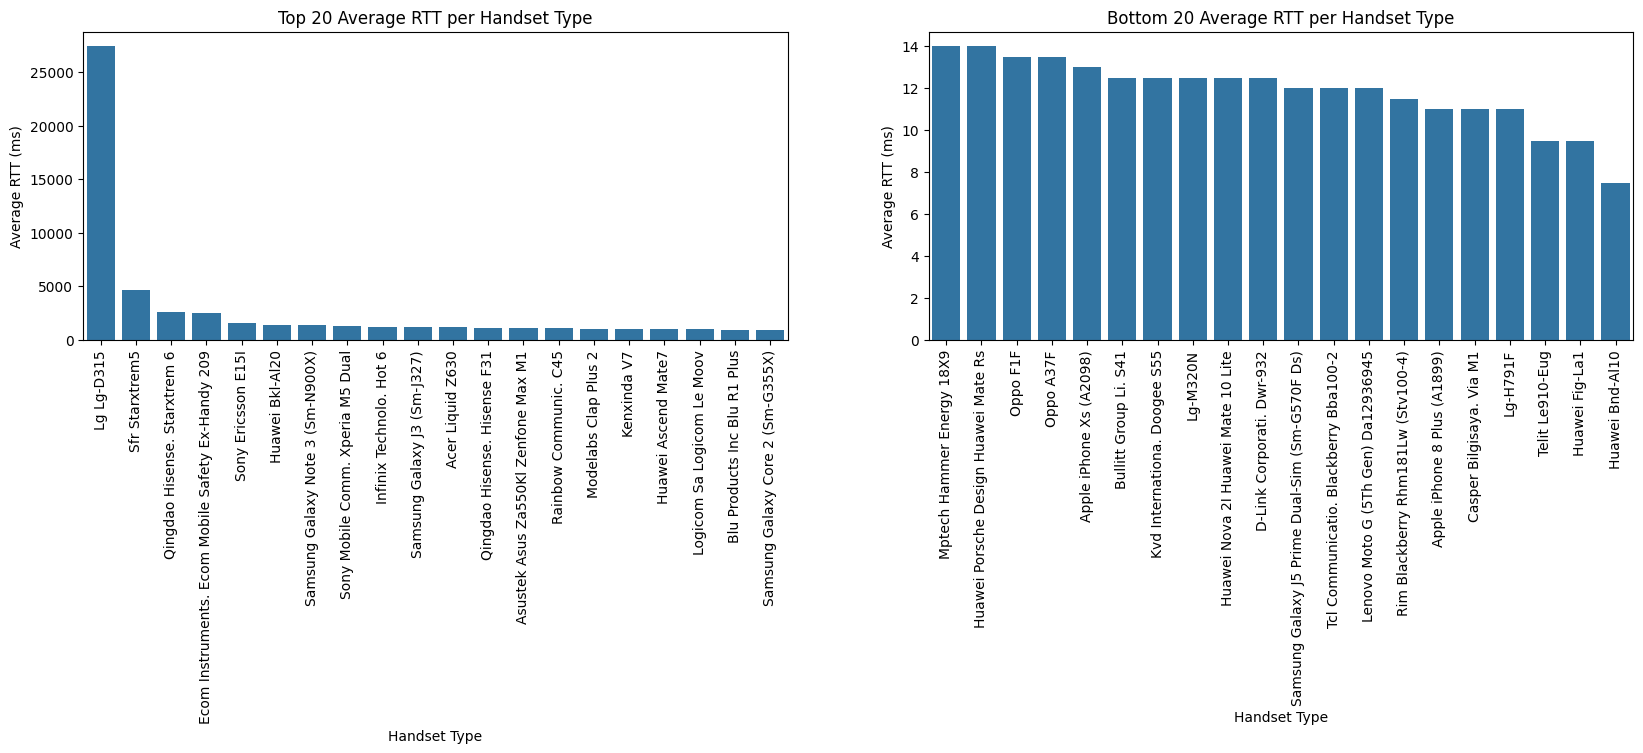

In [85]:
# Set plot size
plt.figure(figsize=(20, 4))

# Plot 1: Distribution of the top 20 avg_rtt among handset types
plt.subplot(1, 2, 1)
sns.barplot(x=sorted_rtt.head(20).index, y=sorted_rtt.head(20)['avg_rtt'])
plt.title('Top 20 Average RTT per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average RTT (ms)')
plt.xticks(rotation=90)  # Rotate handset names by 90 degrees

# Plot 2: Distribution of the bottom 20 avg_rt among handset types
plt.subplot(1, 2, 2)
sns.barplot(x=sorted_rtt.tail(20).index, y=sorted_rtt.tail(20)['avg_rtt'])
plt.title('Bottom 20 Average RTT per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average RTT (ms)')
plt.xticks(rotation=90)  # Rotate handset names by 90 degrees

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

- Display the top 20 and bottom 20 for the average tcp retransmittion

In [86]:
tcp_sorted = handset_grouping.sort_values(by='avg_tcp_rt', ascending=False)

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_3980\3748409379.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


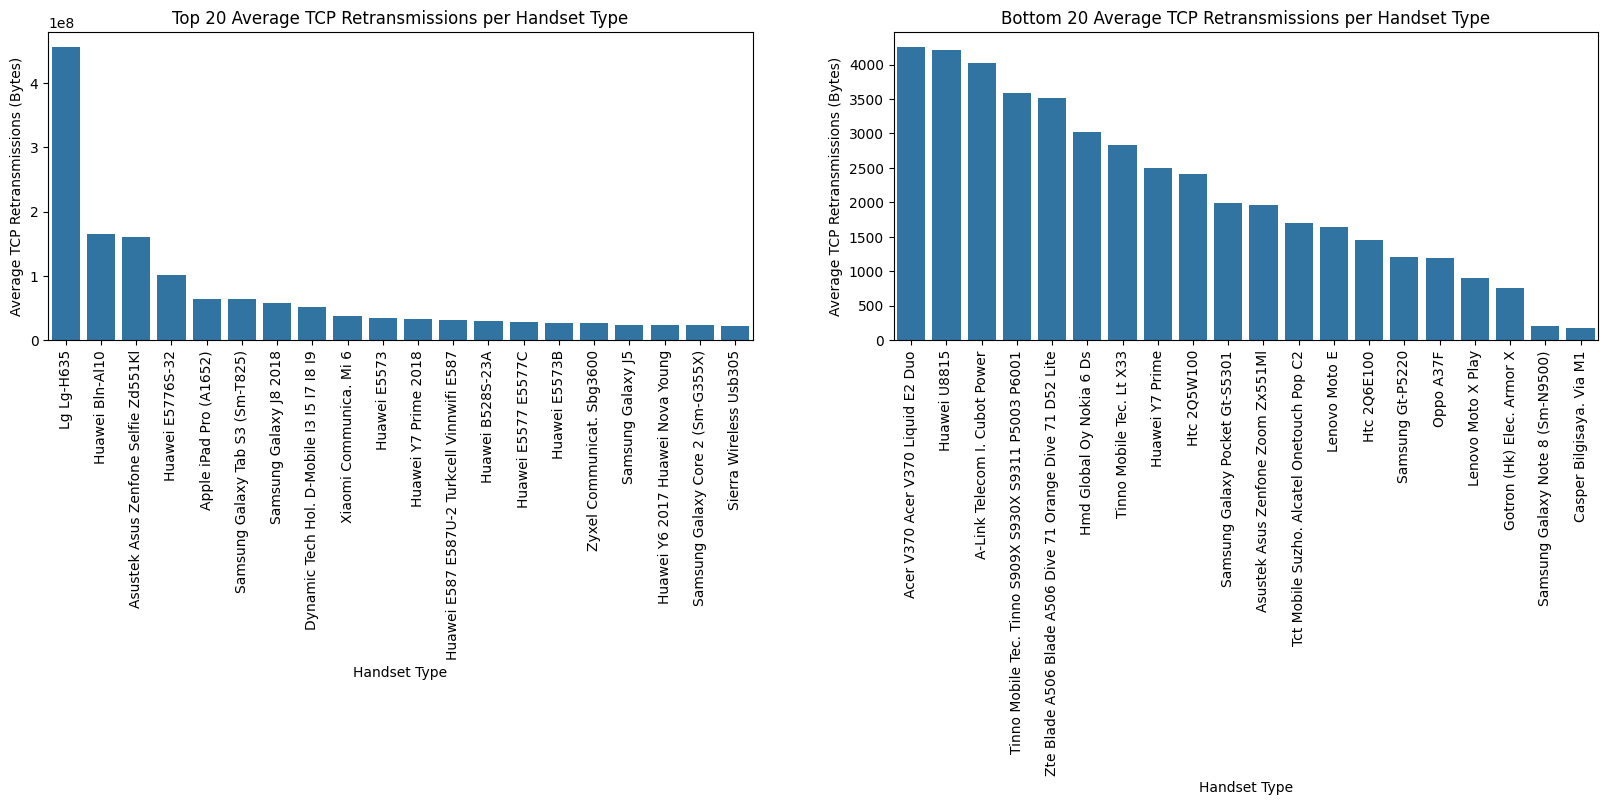

In [87]:
# Set plot size
plt.figure(figsize=(20, 4))

# Plot 1: Distribution of the top 20 avg_tcp_rt among handset types
plt.subplot(1, 2, 1)
sns.barplot(x=tcp_sorted.head(20).index, y=tcp_sorted.head(20)['avg_tcp_rt'])
plt.title('Top 20 Average TCP Retransmissions per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmissions (Bytes)')
plt.xticks(rotation=90)  # Rotate handset names by 90 degrees

# Plot 2: Distribution of the bottom 20 avg_rt among handset types
plt.subplot(1, 2, 2)
sns.barplot(x=tcp_sorted.tail(20).index, y=tcp_sorted.tail(20)['avg_tcp_rt'])
plt.title('Bottom 20 Average TCP Retransmissions per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmissions (Bytes)')
plt.xticks(rotation=90)  # Rotate handset names by 90 degrees

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

#### Interpretation

1) ##### RTT Plots

    - **Dominating Device (Lg D315)**: One clear observation is that the "Lg D315" device shows an abnormally high average RTT value of over 25,000 ms, which is significantly higher than all other handsets. This could indicate either a performance issue related to network latency for this device or possibly some outliers or abnormal data points skewing the results.
    - **Other Devices**: The remaining devices in the top 20 still show high average RTTs, but they are much lower than the "Lg D315." The next highest devices, such as "Sfr Starxtrem 5" and "Qingdao Hisense Starxtrem 6," exhibit average RTTs around 1,000 to 3,000 ms. These values, while smaller, could still indicate significant network delays or issues related to the performance of these devices.
    
    ##### Overall Insights:
    - Handset types that have high latency(are in the top 20) are devices that were released a long time ago. Older devices often have slower network interfaces, outdated hardware, or software optimizations that can't fully handle modern network demands. Additionally, older devices may not support newer, faster network technologies like 4G LTE or 5G, which can result in higher latency.


2)  ##### TCP Retransmission Plots

    - The **LG H635** has an extraordinarily high number of average TCP retransmissions compared to other devices, with retransmissions in the range of 100 million bytes (1e8), which could indicate severe network or hardware issues on that device model.
    - Devices like **Huawei Bln-A10** and **Asustek Asus Zenfone Selfie ZD551K1** also exhibit relatively high TCP retransmissions, but these are significantly lower than the **LG H635**.
    - Other devices like **Huawei E5776s-32**, **Apple iPad Pro (A1652)**, and **Samsung Galaxy J8 (Sm-J825)** have moderate levels of retransmissions, suggesting less severe but still notable network performance issues.

    ##### Overall Insights:
    - The trends we saw earlier for RTT also happen to be present here, older hardware tends to have lower network performance and hence has bad TCP retransmission rates
